In [15]:
# 测试用例说明地址：http://www.infoq.com/cn/articles/predict-airbnb-listing-price
# 测试数据下载地址：http://insideairbnb.com/get-the-data.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from os import chdir
chdir('/Users/yangwm/flask/linkdata_api_py')
import app.lib.sklearn_classification_lib as classification
import app.lib.espandas as espandas
from  app.lib.elasticsearch_util import Elasticsearch_Util

LISTINGSFILE = '/Users/yangwm/flask/linkdata_api_py/app/jupyter_test/airbnbdata/listings.csv'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
# df = pd.read_csv(LISTINGSFILE, usecols=cols)

es_util = Elasticsearch_Util()
es_index_name = "machinelearning*"
es_type_name = "ml-airbnbdata"

query_column_data = {"_source": {
                            "include": cols
                      }, "query": {
                            "match_all": {}
                      }, "size": 10000
                    }

df = es_util.es_read_querybody(es_index_name, es_type_name, query_column_data)
print df.shape

/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


ImportError: No module named espandas

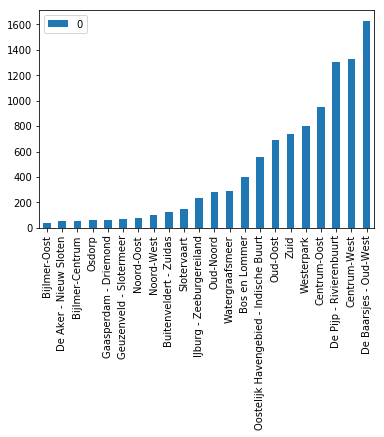

In [20]:
classification.showInfo(df)

nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [21]:
# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [22]:
df = df[df.bedrooms == 1]

# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)

In [23]:
print df

# instant_bookable列是个boolean类型的值。
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns

ValueError: labels ['instant_f'] not contained in axis

In [12]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

NameError: name 'alldata' is not defined

Text(0,0.5,u'Median Absolute Error')

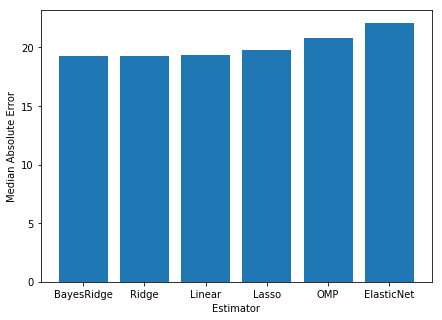

In [9]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [13]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 0.9 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_

/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/yangwm/miniconda2/envs/linkdata/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_abs

Text(0,0.5,u'Least Absolute Deviation')

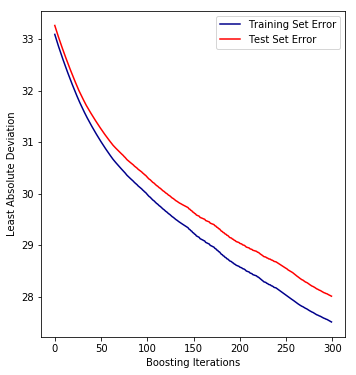

In [14]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')